In [ ]:
import os
import torch
from omegaconf import DictConfig, OmegaConf

from deepmash.data_processing.constants import *
from deepmash.data_processing.common import get_dataloaders, ToLogMel, get_vocal_rms
from deepmash.data_processing.gtzan_stems import GTZANStemsDataset
from deepmash.data_processing.musdb18 import MUSDB18Dataset

from deepmash.models.cocola_cnn import CocolaCNN
from deepmash.models.cnn import CNN

from deepmash.utils.utils import get_device
from deepmash.utils.plotting_utils import display_random_chunk

from deepmash.models.train import training_run

# reload imported modules automatically (so you dont have to restart kernel when changing .py files)
%load_ext autoreload
%autoreload 2

config: DictConfig = OmegaConf.load("../../../config/default.yaml") # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'model': {'name': 'cocola_cnn', 'model_name': 'resnet18', 'weights': 'DEFAULT', 'embedding_dim': 128, 'learning_rate': 0.0001, 'dropout_p': 0.1, 'weight_decay': 1e-05, 'scheduler_patience': 5, 'scheduler_factor': 0.5}, 'training': {'max_epochs': 50, 'batch_size': 16, 'num_workers': 0, 'overfit_batches': 0.0, 'logger_dir': '../logs', 'log_name': 'baseline'}, 'audio': {'target_sample_rate': 16000, 'chunk_duration_sec': 15, 'min_chunk_duration_sec': 5, 'n_mels': 64, 'f_min': 60, 'f_max': 7800, 'n_fft': 1024, 'hop_size': 320, 'vocal_energy_threshold': 0.01}, 'data': {'input_root': '/data/genres_stems', 'processed_root': '/data/processed', 'save_model': '/data/saved_models/baseline', 'output': '/results/baseline'}, 'dataset': {'name': 'gtzan_stems', 'seed': 42, 'batch_size': 16, 'split': 'train', 'num_workers': 0, 'val_split': 0.1, 'test_split': 0.1}, 'query': {'embeddings_prefix': 'dataset', 'which_query': 'vocal', 'which_catalogue': 'instr', 'top_k': 5}}

In [7]:
config.data.input_root = "../data/gtzan-stems"
config.data.processed_root = "../data/gtzan-stems-processed"

ds_gtzan = GTZANStemsDataset(
    config=config,
    already_preprocessed=True,
    preprocess_transform=ToLogMel(config=config),
)

config.data.input_root = "../data/musdb18"
config.data.processed_root = "../data/musdb18-processed"

ds_musdb_train = MUSDB18Dataset(
    config=config,
    split="train",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(config=config),
)
ds_musdb_test = MUSDB18Dataset(
    config=config,
    split="test",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(config=config),
)

print(len(ds_gtzan), len(ds_musdb_train), len(ds_musdb_test))
print(ds_gtzan[42].vocals.shape, ds_musdb_train[42].vocals.shape)

Preprocessing stems from ../data/musdb18/train to ../data/musdb18-processed/train ...


  0%|          | 0/83 [00:00<?, ?it/s]

Preprocessing stems from ../data/musdb18/test to ../data/musdb18-processed/test ...


  0%|          | 0/50 [00:00<?, ?it/s]

1535 1243 841
torch.Size([64, 751]) torch.Size([64, 751])


In [9]:
# check that dataloaders and forward-pass works

train_loader, val_loader, test_loader = get_dataloaders(
    dataset=ds_musdb_train,
    config=config.dataset
)

device = get_device()
print(f"Using device: {device}")

model = CNN(config=config.model)
model = model.to(device)

batch = next(iter(train_loader))
batch = batch.to(device)
print(batch.vocals.shape, batch.non_vocals.shape)

model(batch).shape

Using device: mps
torch.Size([16, 64, 751]) torch.Size([16, 64, 751])


torch.Size([16, 16])

tensor(35.8186) tensor(16.5338) tensor(12.0872) tensor(96.4801)


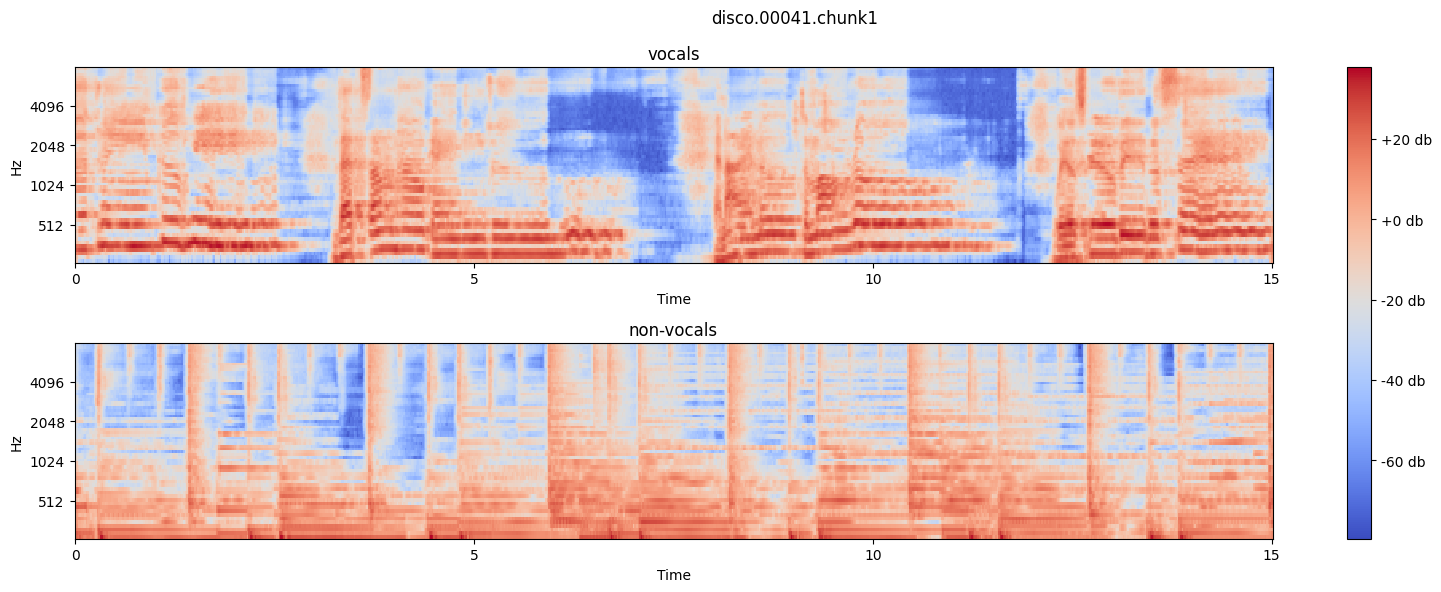

In [67]:
# check vocal energy distribution
ds = ds_gtzan
vocal_energy = torch.tensor([get_vocal_rms(sample.vocals) for sample in ds])
print(vocal_energy.mean(), vocal_energy.std(), vocal_energy.min(), vocal_energy.max())

# check audio / spectrograms of some samples
for _ in range(1):
    display_random_chunk(ds)

In [ ]:
config.training.max_epochs = 100
config.training.batch_size = 32
config.training.num_workers = 0
config.training.overfit_batches = 0
config.training.logger_dir = "../logs"
config.training.log_name = "demo"

config.model.learning_rate = 1e-3
config.model.embedding_dim = 64

model = CNN(config=config.model)

trainer = training_run(
    dataset=ds_gtzan,
    model=model,
    config=config,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


{'name': 'cocola_cnn', 'model_name': 'resnet18', 'weights': 'DEFAULT', 'embedding_dim': 64, 'learning_rate': 0.001, 'dropout_p': 0.1, 'weight_decay': 1e-05, 'scheduler_patience': 5, 'scheduler_factor': 0.5}



  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | CNNEncoder         | 11.2 M | train
1 | layer_norm | LayerNorm          | 128    | train
2 | tanh       | Tanh               | 0      | train
3 | similarity | BilinearSimilarity | 4.1 K  | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.854    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

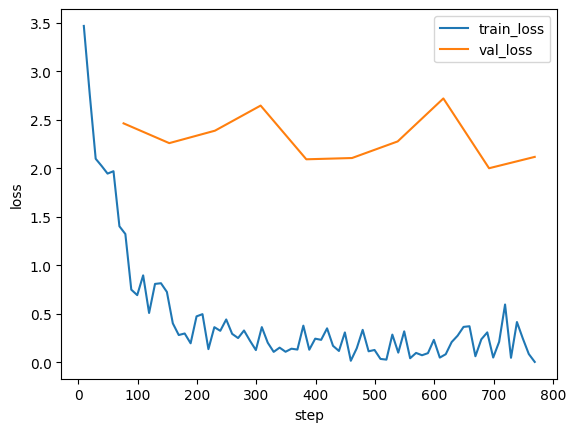

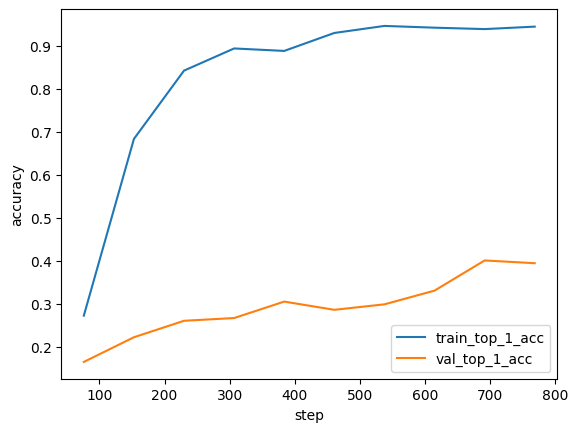

In [40]:
# plot training curves
import matplotlib.pyplot as plt
import pandas as pd

metrics_path = os.path.join(
    config.training.logger_dir,
    config.training.log_name,
    "version_3", "metrics.csv"
)
metrics_df = pd.read_csv(metrics_path)

step = metrics_df["step"]

train_loss = metrics_df["train_loss"]
plt.plot(step[~train_loss.isna()], train_loss[~train_loss.isna()], label="train_loss")
val_loss = metrics_df["val_loss"]
plt.plot(step[~val_loss.isna()], val_loss[~val_loss.isna()], label="val_loss")
plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.show()

train_top_1 = metrics_df["train_top_1"]
plt.plot(step[~train_top_1.isna()], train_top_1[~train_top_1.isna()], label="train_top_1_acc")
val_top_1 = metrics_df["val_top_1"]
plt.plot(step[~val_top_1.isna()], val_top_1[~val_top_1.isna()], label="val_top_1_acc")
plt.xlabel("step"); plt.ylabel("accuracy"); plt.legend(); plt.show()